***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>


In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

from statsmodels.stats.outliers_influence import variance_inflation_factor

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [3]:
def model_build(model,X_train,Y_train,X_test,Y_Test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [4]:
df=pd.read_csv('Html.csv')
df.drop(['Unnamed: 0','Malicious'],axis=1,inplace=True)

df.rename(columns={'Malicious':'Target'},inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'functions' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)

rem=['link_rel_wlwmanifest','script_src_absolute','base_count','img_src_relative','link_href_relative',
     'form_action_absolute','tbody_count','link_count',  'base_href_absolute', 'img_srcset_relative','link_rel_EditURI',
     'form_enctype_application/x-www-form-urlencoded','a_href_relative','iframe_src_absolute',
     'iframe_sandbox_allow_same_origin_count','a_href_absolute','base_href_relative','link_type_application/wlwmanifest+xml'
     ,'form_action_https','form_action_out_of_domain','nofollow_count','img_count','img_src_http','script_src_http',
     'link_href_http','a_href_http','a_href_out_of_domain','iframe_src_http','number_of_cookies','number_of_non_http_only_cookies']

df.drop(rem,axis=1,inplace=True)

print("Shape of our dataset:",df.shape)

Shape of our dataset: (43491, 1436)


#### Let us analyze the balance of classes

In [5]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [6]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

0 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43491, 1436)


#### check to see which features have less than 5% varying data

In [7]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

1297 columns have more than 95% same values


In [8]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [9]:
columns=col_values[col_values['95_%_same_values']==False].index.values
columns=columns.tolist()
# rem=['http_header_expect-ctreport-uri','http_header_vary_accept-encoding','http_header_marco_contenttext',
#      'http_header_vary_user-agent']
# for col in rem:
#     columns.remove(col)
columns.append('Target')
http_columns=columns
len(http_columns)

139

In [10]:
df_sel=df[http_columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for HTML experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
number_of_unsecure_cookies,-0.349525,0.000000e+00,-157.732419,0.000000e+00
script_src_.js,-0.319546,0.000000e+00,-142.596194,0.000000e+00
script_count,-0.315619,0.000000e+00,-142.448699,0.000000e+00
script_src_relative,-0.310931,0.000000e+00,-135.577261,0.000000e+00
script_src_https,-0.271077,0.000000e+00,-126.553948,0.000000e+00
script_async_true,-0.245742,0.000000e+00,-118.214320,0.000000e+00
link_rel_canonical,-0.276351,0.000000e+00,-114.117813,0.000000e+00
div_count,-0.231558,0.000000e+00,-113.026088,0.000000e+00
script_type_text/javascript,-0.264055,0.000000e+00,-111.582561,0.000000e+00



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


#### The ttest conduncted supports the results of point biserial correlation. 

#### Hence, we see that all the features we selected are related to the dependent variable.

### Lets start by building some basic models 

In [11]:
http_columns=num_stats_js.index.values[0:50]

In [14]:
print("Features we will be using:")
http_columns=list(http_columns)
http_columns

Features we will be using:


['number_of_unsecure_cookies',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'meta_http-equiv_X-UA-Compatible',
 'link_href_https',
 'img_src_absolute',
 'img_src_https',
 'iframe_src_relative',
 'link_rel_shortcut icon',
 'iframe_src_https',
 'a_href_https',
 'link_href_.ico',
 'link_href_absolute',
 'link_rel_stylesheet',
 'number_of_http_only_cookies',
 'img_src_.jpg',
 'link_rel_icon',
 'img_src_out_of_domain',
 'link_href_.png',
 'link_href_.css',
 'ul_count',
 'li_count',
 'link_href_out_of_domain',
 'link_type_image/x-icon',
 'link_rel_manifest',
 'iframe_src_.html',
 'span_count',
 'iframe_src_out_of_domain',
 'form_action_relative',
 'img_src_.png',
 'link_type_text/css',
 'link_rel_apple-touch-icon',
 'link_type_image/png',
 'meta_charset_utf-8',
 'nav_count',
 'style_count',
 'meta_count',
 'f

In [15]:
### Preparing our training and test sets
X=df[http_columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [16]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [17]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [18]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,http_columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.8792825937
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29493   209    29702
True        3991  1099     5090
__all__    33484  1308    34792

Accuracy of the model for test data is: 0.876882400276
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7361    51     7412
True        1020   267     1287
__all__     8381   318     8699



Logistic Regression
Accuracy of the model for training data is: 0.875057484479
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26525  3177    29702
True        1170  3920     5090
__all__    27695  7097    34792

Accuracy of the model for test data is: 0.875043108403
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6625   787     7412
True         300   987     1287
__all__     6925  1774     8699



RandomForest Classifier
Accuracy of the model for training data is: 0.908111060014
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26674  3028    29702
True         169  4921     5090
__all__    26843  7949    34792

Accuracy of the model for test data is: 0.900563283136
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6674   738     7412
True         127  1160     1287
__all__     6801  1898     8699



Adaoost Classifier
Accuracy of the model for training data is: 0.885146010577
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26400  3302    29702
True         694  4396     5090
__all__    27094  7698    34792

Accuracy of the model for test data is: 0.884239567766
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6595   817     7412
True         190  1097     1287
__all__     6785  1914     8699



GradientBoosting Classifier
Accuracy of the model for training data is: 0.89486088756
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26620  3082    29702
True         576  4514     5090
__all__    27196  7596    34792

Accuracy of the model for test data is: 0.89516036326
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6671   741     7412
True         171  1116     1287
__all__     6842  1857     8699



ExtraTree Classifier
Accuracy of the model for training data is: 0.910266727983
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26687  3015    29702
True         107  4983     5090
__all__    26794  7998    34792

Accuracy of the model for test data is: 0.900563283136
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6677   735     7412
True         130  1157     1287
__all__     6807  1892     8699



Bagging Classifier
Accuracy of the model for training data is: 0.908772131524
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26676  3026    29702
True         148  4942     5090
__all__    26824  7968    34792

Accuracy of the model for test data is: 0.898379124037
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6656   756     7412
True         128  1159     1287
__all__     6784  1915     8699



Neural Network-1
The accuracy of the model on training data is: 0.89770636928


Predicted  False  True  __all__
Actual                         
False      26371  3331    29702
True         228  4862     5090
__all__    26599  8193    34792

The accuracy of the model on test data is: 0.886883549833


Predicted  False  True  __all__
Actual                         
False       6559   853     7412
True         131  1156     1287
__all__     6690  2009     8699

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [19]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [20]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.879283,1099.0,29493.0,209.0,3991.0,0.007037,0.784086
LogisticRegression,0.875057,3920.0,26525.0,3177.0,1170.0,0.106962,0.229862
RandomForestClassifier,0.908111,4921.0,26674.0,3028.0,169.0,0.101946,0.033202
AdaBoostClassifier,0.885146,4396.0,26400.0,3302.0,694.0,0.111171,0.136346
GradientBoostingClassifier,0.894861,4514.0,26620.0,3082.0,576.0,0.103764,0.113163
ExtraTreeClassifier,0.910267,4983.0,26687.0,3015.0,107.0,0.101508,0.021022
BaggingClassifier,0.908772,4942.0,26676.0,3026.0,148.0,0.101879,0.029077
Neural Network-1,0.897706,4862.0,26371.0,3331.0,228.0,0.112147,0.044794


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.876882,267.0,7361.0,51.0,1020.0,0.006881,0.792541,0.600289
LogisticRegression,0.875043,987.0,6625.0,787.0,300.0,0.106179,0.233100,0.830360
RandomForestClassifier,0.900563,1160.0,6674.0,738.0,127.0,0.099568,0.098679,0.900876
AdaBoostClassifier,0.884240,1097.0,6595.0,817.0,190.0,0.110227,0.147630,0.871072
GradientBoostingClassifier,0.895160,1116.0,6671.0,741.0,171.0,0.099973,0.132867,0.883580
ExtraTreeClassifier,0.900563,1157.0,6677.0,735.0,130.0,0.099164,0.101010,0.899913
BaggingClassifier,0.898379,1159.0,6656.0,756.0,128.0,0.101997,0.099456,0.899274
Neural Network-1,0.886884,1156.0,6559.0,853.0,131.0,0.115084,0.101787,0.899274


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [21]:
feat_impt_plot(np.average(feat_imp,axis=0),http_columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [23]:
df.reset_index(inplace=True)
http_columns.append('domain')

df_min=df[http_columns]
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 4950 features
EntitySet scattered to workers in 5.622 seconds
Elapsed: 00:36 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [24]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [25]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [26]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [27]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [28]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [29]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [30]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [35]:
X=fs[feature_selection_df[feature_selection_df.Total>=2]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(43491, 65)

In [36]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['link_href_out_of_domain / link_href_absolute',
 'script_src_https / script_src_relative',
 'script_src_.js / script_src_relative',
 'script_src_.js / script_count',
 'script_async_true / script_count',
 'number_of_unsecure_cookies + script_src_out_of_domain',
 'number_of_unsecure_cookies + script_src_.js',
 'number_of_unsecure_cookies',
 'number_of_http_only_cookies + number_of_unsecure_cookies',
 'link_type_image/png + number_of_unsecure_cookies',
 'link_rel_stylesheet + number_of_unsecure_cookies',
 'link_rel_manifest + number_of_unsecure_cookies',
 'link_href_.png + number_of_unsecure_cookies',
 'link_href_.ico + number_of_unsecure_cookies',
 'iframe_src_out_of_domain + number_of_unsecure_cookies',
 'iframe_src_https + number_of_unsecure_cookies',
 'a_href_https / a_count',
 'script_type_text/javascript / script_count',
 'script_src_relative / script_count',
 'script_src_out_of_domain / script_src_relative',
 'script_src_out_of_domain / script_count',
 'script_src_https / script_c

In [37]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [38]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.878736491147
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29492   209    29701
True        4010  1081     5091
__all__    33502  1290    34792

Accuracy of the model for test data is: 0.875158064145
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7355    58     7413
True        1028   258     1286
__all__     8383   316     8699



Logistic Regression
Accuracy of the model for training data is: 0.88638192688
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26387  3314    29701
True         639  4452     5091
__all__    27026  7766    34792

Accuracy of the model for test data is: 0.88446947925
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6588   825     7413
True         180  1106     1286
__all__     6768  1931     8699



RandomForest Classifier
Accuracy of the model for training data is: 0.904978155898
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26579  3122    29701
True         184  4907     5091
__all__    26763  8029    34792

Accuracy of the model for test data is: 0.894240717324
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6619   794     7413
True         126  1160     1286
__all__     6745  1954     8699



Adaoost Classifier
Accuracy of the model for training data is: 0.883134053805
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26267  3434    29701
True         632  4459     5091
__all__    26899  7893    34792

Accuracy of the model for test data is: 0.882975054604
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6573   840     7413
True         178  1108     1286
__all__     6751  1948     8699



GradientBoosting Classifier
Accuracy of the model for training data is: 0.890693262819
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26497  3204    29701
True         599  4492     5091
__all__    27096  7696    34792

Accuracy of the model for test data is: 0.887918151512
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6601   812     7413
True         163  1123     1286
__all__     6764  1935     8699



ExtraTree Classifier
Accuracy of the model for training data is: 0.906817659232
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26588  3113    29701
True         129  4962     5091
__all__    26717  8075    34792

Accuracy of the model for test data is: 0.89401080584
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6619   794     7413
True         128  1158     1286
__all__     6747  1952     8699



Bagging Classifier
Accuracy of the model for training data is: 0.904978155898
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26588  3113    29701
True         193  4898     5091
__all__    26781  8011    34792

Accuracy of the model for test data is: 0.89458558455
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6624   789     7413
True         128  1158     1286
__all__     6752  1947     8699



Neural Network-1
The accuracy of the model on training data is: 0.897275235686


Predicted  False  True  __all__
Actual                         
False      26318  3383    29701
True         191  4900     5091
__all__    26509  8283    34792

The accuracy of the model on test data is: 0.887343372801


Predicted  False  True  __all__
Actual                         
False       6547   866     7413
True         114  1172     1286
__all__     6661  2038     8699

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [39]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [46]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.886411,4640.0,26200.0,3501.0,451.0,0.117875,0.088588
LogisticRegression,0.878363,4424.0,26136.0,3565.0,667.0,0.120030,0.131016
RandomForestClassifier,0.896413,4952.0,26236.0,3465.0,139.0,0.116663,0.027303
AdaBoostClassifier,0.880116,4490.0,26131.0,3570.0,601.0,0.120198,0.118051
GradientBoostingClassifier,0.886411,4632.0,26208.0,3493.0,459.0,0.117605,0.090159
ExtraTreeClassifier,0.898569,5027.0,26236.0,3465.0,64.0,0.116663,0.012571
BaggingClassifier,0.896930,4972.0,26234.0,3467.0,119.0,0.116730,0.023375
Neural Network-1,0.895321,4966.0,26184.0,3517.0,125.0,0.118414,0.024553


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.882400,1151.0,6525.0,888.0,135.0,0.119790,0.104977,0.887617
LogisticRegression,0.878262,1098.0,6542.0,871.0,188.0,0.117496,0.146190,0.868157
RandomForestClassifier,0.889183,1185.0,6550.0,863.0,101.0,0.116417,0.078538,0.902522
AdaBoostClassifier,0.880906,1115.0,6548.0,865.0,171.0,0.116687,0.132970,0.875171
GradientBoostingClassifier,0.884814,1155.0,6542.0,871.0,131.0,0.117496,0.101866,0.890319
ExtraTreeClassifier,0.889642,1189.0,6550.0,863.0,97.0,0.116417,0.075428,0.904078
BaggingClassifier,0.889183,1188.0,6547.0,866.0,98.0,0.116822,0.076205,0.903486
Neural Network-1,0.884469,1195.0,6499.0,914.0,91.0,0.123297,0.070762,0.903486


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [47]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [40]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

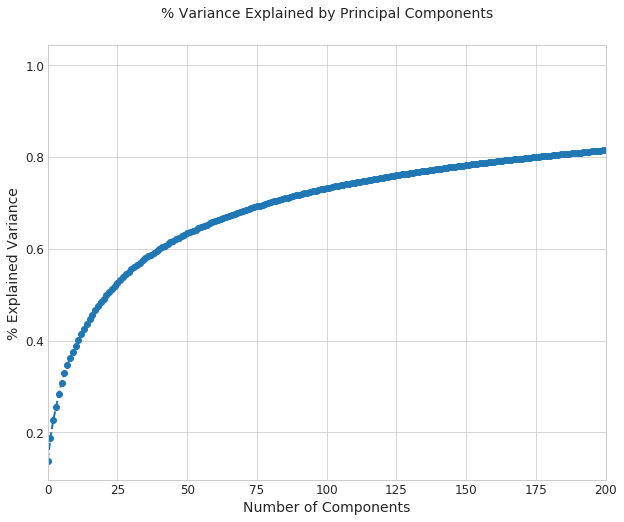

In [41]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [50]:
pca=PCA(n_components=868,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 868 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 868 components is: 0.949128262287


In [45]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

The train/test split ratio is 80:20


In [46]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,868).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.884599908025
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26132  3569    29701
True         446  4645     5091
__all__    26578  8214    34792

Accuracy of the model for test data is: 0.868835498333
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6407  1006     7413
True         135  1151     1286
__all__     6542  2157     8699



Logistic Regression
Accuracy of the model for training data is: 0.892848930789
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26417  3284    29701
True         444  4647     5091
__all__    26861  7931    34792

Accuracy of the model for test data is: 0.886078859639
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6557   856     7413
True         135  1151     1286
__all__     6692  2007     8699



RandomForest Classifier
Accuracy of the model for training data is: 0.908513451368
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26697  3004    29701
True         179  4912     5091
__all__    26876  7916    34792

Accuracy of the model for test data is: 0.8996436372
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6665   748     7413
True         125  1161     1286
__all__     6790  1909     8699



Adaoost Classifier
Accuracy of the model for training data is: 0.890549551621
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26551  3150    29701
True         658  4433     5091
__all__    27209  7583    34792

Accuracy of the model for test data is: 0.889297620416
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6635   778     7413
True         185  1101     1286
__all__     6820  1879     8699



GradientBoosting Classifier
Accuracy of the model for training data is: 0.898051276155
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26702  2999    29701
True         548  4543     5091
__all__    27250  7542    34792

Accuracy of the model for test data is: 0.894815496034
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6657   756     7413
True         159  1127     1286
__all__     6816  1883     8699



ExtraTree Classifier
Accuracy of the model for training data is: 0.910841572775
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26703  2998    29701
True         104  4987     5091
__all__    26807  7985    34792

Accuracy of the model for test data is: 0.898609035521
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6664   749     7413
True         133  1153     1286
__all__     6797  1902     8699



Bagging Classifier
Accuracy of the model for training data is: 0.908887100483
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26694  3007    29701
True         163  4928     5091
__all__    26857  7935    34792

Accuracy of the model for test data is: 0.897689389585
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6654   759     7413
True         131  1155     1286
__all__     6785  1914     8699



Neural Network-1
The accuracy of the model on training data is: 0.907766153139


Predicted  False  True  __all__
Actual                         
False      26593  3108    29701
True         101  4990     5091
__all__    26694  8098    34792

The accuracy of the model on test data is: 0.895505230486


Predicted  False  True  __all__
Actual                         
False       6609   804     7413
True         105  1181     1286
__all__     6714  1985     8699

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [47]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [48]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.884600,4645.0,26132.0,3569.0,446.0,0.120164,0.087606
LogisticRegression,0.892849,4647.0,26417.0,3284.0,444.0,0.110569,0.087213
RandomForestClassifier,0.908513,4912.0,26697.0,3004.0,179.0,0.101141,0.035160
AdaBoostClassifier,0.890550,4433.0,26551.0,3150.0,658.0,0.106057,0.129248
GradientBoostingClassifier,0.898051,4543.0,26702.0,2999.0,548.0,0.100973,0.107641
ExtraTreeClassifier,0.910842,4987.0,26703.0,2998.0,104.0,0.100939,0.020428
BaggingClassifier,0.908887,4928.0,26694.0,3007.0,163.0,0.101242,0.032017
Neural Network-1,0.907766,4990.0,26593.0,3108.0,101.0,0.104643,0.019839


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.868835,1151.0,6407.0,1006.0,135.0,0.135708,0.104977,0.879658
LogisticRegression,0.886079,1151.0,6557.0,856.0,135.0,0.115473,0.104977,0.889775
RandomForestClassifier,0.899644,1161.0,6665.0,748.0,125.0,0.100904,0.097201,0.900948
AdaBoostClassifier,0.889298,1101.0,6635.0,778.0,185.0,0.104951,0.143857,0.875596
GradientBoostingClassifier,0.894815,1127.0,6657.0,756.0,159.0,0.101983,0.123639,0.887189
ExtraTreeClassifier,0.898609,1153.0,6664.0,749.0,133.0,0.101039,0.103421,0.897770
BaggingClassifier,0.897689,1155.0,6654.0,759.0,131.0,0.102388,0.101866,0.897873
Neural Network-1,0.895505,1181.0,6609.0,804.0,105.0,0.108458,0.081649,0.897873


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [49]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,868).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [51]:
print('Features we will be using:\n')
http_columns.remove('domain')
display(http_columns)

Features we will be using:



['number_of_unsecure_cookies',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'meta_http-equiv_X-UA-Compatible',
 'link_href_https',
 'img_src_absolute',
 'img_src_https',
 'iframe_src_relative',
 'link_rel_shortcut icon',
 'iframe_src_https',
 'a_href_https',
 'link_href_.ico',
 'link_href_absolute',
 'link_rel_stylesheet',
 'number_of_http_only_cookies',
 'img_src_.jpg',
 'link_rel_icon',
 'img_src_out_of_domain',
 'link_href_.png',
 'link_href_.css',
 'ul_count',
 'li_count',
 'link_href_out_of_domain',
 'link_type_image/x-icon',
 'link_rel_manifest',
 'iframe_src_.html',
 'span_count',
 'iframe_src_out_of_domain',
 'form_action_relative',
 'img_src_.png',
 'link_type_text/css',
 'link_rel_apple-touch-icon',
 'link_type_image/png',
 'meta_charset_utf-8',
 'nav_count',
 'style_count',
 'meta_count',
 'f

In [52]:
### Preparing our training and test sets
X=df[http_columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [53]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [54]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,http_columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.631943976837
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28804   898    29702
True       20966  8736    29702
__all__    49770  9634    59404

Accuracy of the model for test data is: 0.854121163352
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7111   301     7412
True         968   319     1287
__all__     8079   620     8699



Logistic Regression
Accuracy of the model for training data is: 0.885681098916
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24355   5347    29702
True        1444  28258    29702
__all__    25799  33605    59404

Accuracy of the model for test data is: 0.844120013795
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6119  1293     7412
True          63  1224     1287
__all__     6182  2517     8699



RandomForest Classifier
Accuracy of the model for training data is: 0.944902700155
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26503   3199    29702
True          74  29628    29702
__all__    26577  32827    59404

Accuracy of the model for test data is: 0.896769743649
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6616   796     7412
True         102  1185     1287
__all__     6718  1981     8699



Adaoost Classifier
Accuracy of the model for training data is: 0.903659686216
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25275   4427    29702
True        1296  28406    29702
__all__    26571  32833    59404

Accuracy of the model for test data is: 0.862857799747
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6296  1116     7412
True          77  1210     1287
__all__     6373  2326     8699



GradientBoosting Classifier
Accuracy of the model for training data is: 0.922496801562
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25822   3880    29702
True         724  28978    29702
__all__    26546  32858    59404

Accuracy of the model for test data is: 0.878031957696
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6435   977     7412
True          84  1203     1287
__all__     6519  2180     8699



ExtraTree Classifier
Accuracy of the model for training data is: 0.945576055484
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26505   3197    29702
True          36  29666    29702
__all__    26541  32863    59404

Accuracy of the model for test data is: 0.897114610875
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6621   791     7412
True         104  1183     1287
__all__     6725  1974     8699



Bagging Classifier
Accuracy of the model for training data is: 0.944734361322
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26498   3204    29702
True          79  29623    29702
__all__    26577  32827    59404

Accuracy of the model for test data is: 0.895390274744
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6598   814     7412
True          96  1191     1287
__all__     6694  2005     8699



Neural Network-1
The accuracy of the model on training data is: 0.935930240388


Predicted  False   True  __all__
Actual                          
False      26027   3675    29702
True         131  29571    29702
__all__    26158  33246    59404

The accuracy of the model on test data is: 0.882515231636


Predicted  False  True  __all__
Actual                         
False       6465   947     7412
True          75  1212     1287
__all__     6540  2159     8699

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [55]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [56]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.631944,8736.0,28804.0,898.0,20966.0,0.030234,0.705878
LogisticRegression,0.885681,28258.0,24355.0,5347.0,1444.0,0.180022,0.048616
RandomForestClassifier,0.944903,29628.0,26503.0,3199.0,74.0,0.107703,0.002491
AdaBoostClassifier,0.903660,28406.0,25275.0,4427.0,1296.0,0.149047,0.043633
GradientBoostingClassifier,0.922497,28978.0,25822.0,3880.0,724.0,0.130631,0.024375
ExtraTreeClassifier,0.945576,29666.0,26505.0,3197.0,36.0,0.107636,0.001212
BaggingClassifier,0.944734,29623.0,26498.0,3204.0,79.0,0.107872,0.002660
Neural Network-1,0.935930,29571.0,26027.0,3675.0,131.0,0.123729,0.004410


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.854121,319.0,7111.0,301.0,968.0,0.040610,0.752137,0.603627
LogisticRegression,0.844120,1224.0,6119.0,1293.0,63.0,0.174447,0.048951,0.888301
RandomForestClassifier,0.896770,1185.0,6616.0,796.0,102.0,0.107393,0.079254,0.906676
AdaBoostClassifier,0.862858,1210.0,6296.0,1116.0,77.0,0.150567,0.059829,0.894802
GradientBoostingClassifier,0.878032,1203.0,6435.0,977.0,84.0,0.131813,0.065268,0.901459
ExtraTreeClassifier,0.897115,1183.0,6621.0,791.0,104.0,0.106719,0.080808,0.906237
BaggingClassifier,0.895390,1191.0,6598.0,814.0,96.0,0.109822,0.074592,0.907793
Neural Network-1,0.882515,1212.0,6465.0,947.0,75.0,0.127766,0.058275,0.907793


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [57]:
feat_impt_plot(np.average(feat_imp,axis=0),http_columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [58]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[http_columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",X.shape)


Shape after undersampling (12754, 50)


In [59]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [60]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [61]:
print('Features we will be using:\n')
display(http_columns)

Features we will be using:



['number_of_unsecure_cookies',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'meta_http-equiv_X-UA-Compatible',
 'link_href_https',
 'img_src_absolute',
 'img_src_https',
 'iframe_src_relative',
 'link_rel_shortcut icon',
 'iframe_src_https',
 'a_href_https',
 'link_href_.ico',
 'link_href_absolute',
 'link_rel_stylesheet',
 'number_of_http_only_cookies',
 'img_src_.jpg',
 'link_rel_icon',
 'img_src_out_of_domain',
 'link_href_.png',
 'link_href_.css',
 'ul_count',
 'li_count',
 'link_href_out_of_domain',
 'link_type_image/x-icon',
 'link_rel_manifest',
 'iframe_src_.html',
 'span_count',
 'iframe_src_out_of_domain',
 'form_action_relative',
 'img_src_.png',
 'link_type_text/css',
 'link_rel_apple-touch-icon',
 'link_type_image/png',
 'meta_charset_utf-8',
 'nav_count',
 'style_count',
 'meta_count',
 'f

In [62]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,http_columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.908164265412
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4461   687     5148
True         250  4805     5055
__all__     4711  5492    10203

Accuracy of the model for test data is: 0.905919247354
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1067   162     1229
True          78  1244     1322
__all__     1145  1406     2551



Logistic Regression
Accuracy of the model for training data is: 0.886209938253
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4240   908     5148
True         253  4802     5055
__all__     4493  5710    10203

Accuracy of the model for test data is: 0.897687181497
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1035   194     1229
True          67  1255     1322
__all__     1102  1449     2551



RandomForest Classifier
Accuracy of the model for training data is: 0.942271880819
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4587   561     5148
True          28  5027     5055
__all__     4615  5588    10203

Accuracy of the model for test data is: 0.920423363387
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1101   128     1229
True          75  1247     1322
__all__     1176  1375     2551



Adaoost Classifier
Accuracy of the model for training data is: 0.895618935607
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4351   797     5148
True         268  4787     5055
__all__     4619  5584    10203

Accuracy of the model for test data is: 0.909447275578
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1067   162     1229
True          69  1253     1322
__all__     1136  1415     2551



GradientBoosting Classifier
Accuracy of the model for training data is: 0.912574732922
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4471   677     5148
True         215  4840     5055
__all__     4686  5517    10203

Accuracy of the model for test data is: 0.914151313211
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1081   148     1229
True          71  1251     1322
__all__     1152  1399     2551



ExtraTree Classifier
Accuracy of the model for training data is: 0.945408213271
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4604   544     5148
True          13  5042     5055
__all__     4617  5586    10203

Accuracy of the model for test data is: 0.918463347707
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1104   125     1229
True          83  1239     1322
__all__     1187  1364     2551



Bagging Classifier
Accuracy of the model for training data is: 0.941193766539
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4599   549     5148
True          51  5004     5055
__all__     4650  5553    10203

Accuracy of the model for test data is: 0.918855350843
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1094   135     1229
True          72  1250     1322
__all__     1166  1385     2551



Neural Network-1
The accuracy of the model on training data is: 0.935803195197


Predicted  False  True  __all__
Actual                         
False       4513   635     5148
True          20  5035     5055
__all__     4533  5670    10203

The accuracy of the model on test data is: 0.911015288122


Predicted  False  True  __all__
Actual                         
False       1054   175     1229
True          52  1270     1322
__all__     1106  1445     2551

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [63]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [64]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.908164,4805.0,4461.0,687.0,250.0,0.133450,0.049456
LogisticRegression,0.886210,4802.0,4240.0,908.0,253.0,0.176379,0.050049
RandomForestClassifier,0.942272,5027.0,4587.0,561.0,28.0,0.108974,0.005539
AdaBoostClassifier,0.895619,4787.0,4351.0,797.0,268.0,0.154817,0.053017
GradientBoostingClassifier,0.912575,4840.0,4471.0,677.0,215.0,0.131507,0.042532
ExtraTreeClassifier,0.945408,5042.0,4604.0,544.0,13.0,0.105672,0.002572
BaggingClassifier,0.941194,5004.0,4599.0,549.0,51.0,0.106643,0.010089
Neural Network-1,0.935803,5035.0,4513.0,635.0,20.0,0.123349,0.003956


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.905919,1244.0,1067.0,162.0,78.0,0.131814,0.059002,0.904592
LogisticRegression,0.897687,1255.0,1035.0,194.0,67.0,0.157852,0.050681,0.895734
RandomForestClassifier,0.920423,1247.0,1101.0,128.0,75.0,0.104150,0.056732,0.919559
AdaBoostClassifier,0.909447,1253.0,1067.0,162.0,69.0,0.131814,0.052194,0.907996
GradientBoostingClassifier,0.914151,1251.0,1081.0,148.0,71.0,0.120423,0.053707,0.912935
ExtraTreeClassifier,0.918463,1239.0,1104.0,125.0,83.0,0.101709,0.062784,0.917754
BaggingClassifier,0.918855,1250.0,1094.0,135.0,72.0,0.109845,0.054463,0.917846
Neural Network-1,0.911015,1270.0,1054.0,175.0,52.0,0.142392,0.039334,0.917846


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [65]:
feat_impt_plot(np.average(feat_imp,axis=0),http_columns)

In [66]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')